# UNIVERSIDAD ORT URUGUAY
**SANTIAGO BELZA - 286184**  
**VANESA ALLAN - 247079**

## Exploración de Métodos para Predicción de Tráfico Vehicular: Autorregresivos, Redes Recurrentes, Autoencoders y Modelos Basados en Grafos

### Contexto del Script de Análisis

El siguiente script en Python forma parte del proceso de análisis para la exploración de modelos de predicción de tráfico vehicular en el marco de la investigación realizada. Este script contiene la implementación de Stacked AutoEncoders y greedy layer wise pretraining.


### Importación de librerías y conexión a datos

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
from math import sqrt
import datetime
from sklearn.datasets import make_blobs
from keras.optimizers import SGD
from keras.utils import to_categorical
from matplotlib import pyplot
import tensorflow as tf
import datetime, os
from sklearn.preprocessing import OneHotEncoder

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
! cp "/content/drive/My Drive/01_ORT_Master_en_Big_Data/09_Tesis/El_principio_del_fin/07_Datos/Dataset/Datos_transito.csv" "/content/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount("/content/drive")
! cp "/content/drive/My Drive/01_ORT_Master_en_Big_Data/09_Tesis/El_principio_del_fin/07_Datos/Dataset/data_val_transito.csv" "/content/"
#! cp "/content/drive/MyDrive/MasterBigData/data_val_transito.csv" "/content/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_train = pd.read_csv('Datos_transito.csv')
data_val = pd.read_csv('data_val_transito.csv')


### Preprocesamiento de datos

Se filtran los datos para aquellas latitudes y longitudes asociadas a la zona 5

In [ ]:
data_train = data_train.loc[data_train['zona'] == 5]
data_val = data_val.loc[data_val['zona'] == 5]

In [ ]:
# Convertir la columna 'FechaHora' a tipo datetime
data_train['FechaHora'] = pd.to_datetime(data_train['FechaHora'])
data_val['FechaHora'] = pd.to_datetime(data_val['FechaHora'])

print(data_train.head())

         latitud   longitud           FechaHora  velocidad_agrupada  \
17571 -34.905258 -56.134153 2023-09-01 00:00:00           36.333333   
17572 -34.905258 -56.134153 2023-09-01 00:15:00           31.888889   
17573 -34.905258 -56.134153 2023-09-01 00:30:00           31.000000   
17574 -34.905258 -56.134153 2023-09-01 00:45:00           32.111111   
17575 -34.905258 -56.134153 2023-09-01 01:00:00           32.333333   

       volumen_agrupada  dsc_avenida                   key  zona  
17571              57.0  26 de Marzo  -34.905258-56.134153     5  
17572              37.0  26 de Marzo  -34.905258-56.134153     5  
17573              31.0  26 de Marzo  -34.905258-56.134153     5  
17574              31.0  26 de Marzo  -34.905258-56.134153     5  
17575              25.0  26 de Marzo  -34.905258-56.134153     5  


In [ ]:
df = data_train
df_val = data_val
df

,latitud,longitud,FechaHora,velocidad_agrupada,volumen_agrupada,dsc_avenida,key,zona
17571,-34.905258,-56.134153,2023-09-01 00:00:00,36.333333,57.0,26 de Marzo,-34.905258-56.134153,5
17572,-34.905258,-56.134153,2023-09-01 00:15:00,31.888889,37.0,26 de Marzo,-34.905258-56.134153,5
17573,-34.905258,-56.134153,2023-09-01 00:30:00,31.000000,31.0,26 de Marzo,-34.905258-56.134153,5
17574,-34.905258,-56.134153,2023-09-01 00:45:00,32.111111,31.0,26 de Marzo,-34.905258-56.134153,5
17575,-34.905258,-56.134153,2023-09-01 01:00:00,32.333333,25.0,26 de Marzo,-34.905258-56.134153,5
...,...,...,...,...,...,...,...,...
1165538,-34.897400,-56.120289,2023-10-31 23:00:00,22.000000,21.0,Solano Lopez,-34.8974-56.120289,5
1165539,-34.897400,-56.120289,2023-10-31 23:15:00,20.500000,12.0,Solano Lopez,-34.8974-56.120289,5
1165540,-34.897400,-56.120289,2023-10-31 23:30:00,22.000000,15.0,Solano Lopez,-34.8974-56.120289,5
1165541,-34.897400,-56.120289,2023-10-31 23:45:00,22.500000,9.0,Solano Lopez,-34.8974-56.120289,5


In [ ]:
df['latitud_longitud'] = df['latitud'].astype(str) + ',' + df['longitud'].astype(str)
df_val['latitud_longitud'] = df_val['latitud'].astype(str) + ',' + df_val['longitud'].astype(str)


In [ ]:
# Ordenar el DataFrame por la columna 'fecha_hora'
df = df.sort_values(by='FechaHora')
df_val = df_val.sort_values(by='FechaHora')
df

,latitud,longitud,FechaHora,velocidad_agrupada,volumen_agrupada,dsc_avenida,key,zona,latitud_longitud
17571,-34.905258,-56.134153,2023-09-01,36.333333,57.0,26 de Marzo,-34.905258-56.134153,5,"-34.905258,-56.134153"
1153829,-34.887512,-56.129107,2023-09-01,57.000000,16.0,Solano Lopez,-34.887512-56.129107,5,"-34.887512,-56.129107"
796552,-34.901934,-56.138191,2023-09-01,30.666667,71.0,L A de Herrera,-34.901934-56.138191,5,"-34.901934,-56.138191"
591557,-34.886170,-56.130966,2023-09-01,29.333333,21.0,Comercio,-34.88617-56.130966,5,"-34.88617,-56.130966"
204995,-34.886696,-56.109244,2023-09-01,44.777778,130.0,Av Italia,-34.886696-56.109244,5,"-34.886696,-56.109244"
...,...,...,...,...,...,...,...,...,...
808265,-34.905897,-56.136828,2023-11-01,0.000000,0.0,L A de Herrera,-34.905897-56.136828,5,"-34.905897,-56.136828"
486130,-34.898010,-56.124030,2023-11-01,0.000000,0.0,Bv Batlle y Ordonez,-34.89801-56.12403,5,"-34.89801,-56.12403"
29284,-34.905612,-56.135593,2023-11-01,0.000000,0.0,26 de Marzo,-34.905612-56.135593,5,"-34.905612,-56.135593"
1024974,-34.901555,-56.123936,2023-11-01,0.000000,0.0,Rambla,-34.901555-56.123936,5,"-34.901555,-56.123936"


In [ ]:
label_encoder = LabelEncoder()
df['latitud_longitud'] = label_encoder.fit_transform(df['latitud_longitud'])

unique_df = df[['latitud', 'longitud', 'latitud_longitud']].drop_duplicates()
df_val = df_val.merge(unique_df, how='inner', on=['latitud', 'longitud'])
df_val = df_val.drop(['latitud_longitud_x'], axis=1)
df_val.rename(columns={'latitud_longitud_y': 'latitud_longitud'}, inplace=True)
df_val

,latitud,longitud,FechaHora,velocidad_agrupada,volumen_agrupada,dsc_avenida,key,zona,latitud_longitud
0,-34.905258,-56.134153,2023-11-01 00:00:00,32.333333,28.0,26 de Marzo,-34.905258-56.134153,5,18
1,-34.905258,-56.134153,2023-11-01 00:15:00,29.000000,24.0,26 de Marzo,-34.905258-56.134153,5,18
2,-34.905258,-56.134153,2023-11-01 00:30:00,33.555556,29.0,26 de Marzo,-34.905258-56.134153,5,18
3,-34.905258,-56.134153,2023-11-01 00:45:00,31.111111,16.0,26 de Marzo,-34.905258-56.134153,5,18
4,-34.905258,-56.134153,2023-11-01 01:00:00,22.333333,14.0,26 de Marzo,-34.905258-56.134153,5,18
...,...,...,...,...,...,...,...,...,...
77782,-34.905612,-56.135593,2023-11-30 23:00:00,23.666667,8.0,26 de Marzo,-34.905612-56.135593,5,21
77783,-34.905612,-56.135593,2023-11-30 23:15:00,23.666667,7.0,26 de Marzo,-34.905612-56.135593,5,21
77784,-34.905612,-56.135593,2023-11-30 23:30:00,47.666667,12.0,26 de Marzo,-34.905612-56.135593,5,21
77785,-34.905612,-56.135593,2023-11-30 23:45:00,32.333333,5.0,26 de Marzo,-34.905612-56.135593,5,21


In [ ]:
df

,latitud,longitud,FechaHora,velocidad_agrupada,volumen_agrupada,dsc_avenida,key,zona,latitud_longitud
17571,-34.905258,-56.134153,2023-09-01,36.333333,57.0,26 de Marzo,-34.905258-56.134153,5,18
1153829,-34.887512,-56.129107,2023-09-01,57.000000,16.0,Solano Lopez,-34.887512-56.129107,5,6
796552,-34.901934,-56.138191,2023-09-01,30.666667,71.0,L A de Herrera,-34.901934-56.138191,5,16
591557,-34.886170,-56.130966,2023-09-01,29.333333,21.0,Comercio,-34.88617-56.130966,5,0
204995,-34.886696,-56.109244,2023-09-01,44.777778,130.0,Av Italia,-34.886696-56.109244,5,1
...,...,...,...,...,...,...,...,...,...
808265,-34.905897,-56.136828,2023-11-01,0.000000,0.0,L A de Herrera,-34.905897-56.136828,5,22
486130,-34.898010,-56.124030,2023-11-01,0.000000,0.0,Bv Batlle y Ordonez,-34.89801-56.12403,5,13
29284,-34.905612,-56.135593,2023-11-01,0.000000,0.0,26 de Marzo,-34.905612-56.135593,5,21
1024974,-34.901555,-56.123936,2023-11-01,0.000000,0.0,Rambla,-34.901555-56.123936,5,15


In [ ]:
# Convertir la columna 'fecha_hora' a índice del DataFrame
df.set_index('FechaHora', inplace=True)
df_val.set_index('FechaHora', inplace=True)

df.drop(['latitud', 'longitud'], axis=1, inplace=True)
df_val.drop(['latitud', 'longitud'], axis=1, inplace=True)


print(df)

            velocidad_agrupada  volumen_agrupada          dsc_avenida  \
FechaHora                                                               
2023-09-01           36.333333              57.0          26 de Marzo   
2023-09-01           57.000000              16.0         Solano Lopez   
2023-09-01           30.666667              71.0       L A de Herrera   
2023-09-01           29.333333              21.0             Comercio   
2023-09-01           44.777778             130.0            Av Italia   
...                        ...               ...                  ...   
2023-11-01            0.000000               0.0       L A de Herrera   
2023-11-01            0.000000               0.0  Bv Batlle y Ordonez   
2023-11-01            0.000000               0.0          26 de Marzo   
2023-11-01            0.000000               0.0               Rambla   
2023-11-01            0.000000               0.0         Solano Lopez   

                             key  zona  latitud_lo

### Ventana de tiempo (lagging)

In [ ]:
data = df[['latitud_longitud', 'velocidad_agrupada', 'volumen_agrupada']]
# Paso 2: Creación de Lags
lags = 4  # Supongamos que se consideran los últimos 5 periodos de tiempo para predecir
# Crear lag features para velocidad y volumen
for lag in range(1, lags+1):
    # Crear lag features
    data[f'velocidad_lag_{lag}'] = data.groupby('latitud_longitud')['velocidad_agrupada'].shift(lag)
    data[f'volumen_lag_{lag}'] = data.groupby('latitud_longitud')['volumen_agrupada'].shift(lag)

    # Verificar la forma de las matrices generadas
    lag_velocidad_shape = data[f'velocidad_lag_{lag}'].shape
    lag_volumen_shape = data[f'volumen_lag_{lag}'].shape
# Eliminar filas con NaN resultantes de los lags
data.dropna(inplace=True)

# Paso 3: Apilamiento de Datos
# Agrupa las lag features de velocidad y volumen para cada avenida en un solo tensor
X = data.groupby('latitud_longitud').apply(lambda x: x.iloc[:, 3:].values)

<ipython-input-46-57af0d0ae19b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'velocidad_lag_{lag}'] = data.groupby('latitud_longitud')['velocidad_agrupada'].shift(lag)
<ipython-input-46-57af0d0ae19b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'volumen_lag_{lag}'] = data.groupby('latitud_longitud')['volumen_agrupada'].shift(lag)


In [ ]:
Y = data.groupby('latitud_longitud')['volumen_agrupada'].agg(list)
#y = y.filter(X.index)

In [ ]:
X = np.stack(X)
# Verificar la forma del tensor resultante
print("Dimensiones del x de entrada:", X.shape)
y = np.stack(Y)
# Verificar la forma del tensor resultante
print("Dimensiones del y de entrada:", y.shape)

Dimensiones del x de entrada: (27, 5853, 8)
Dimensiones del y de entrada: (27, 5853)


### Ajustes de dimensionalidad de input shape

In [ ]:
X = np.transpose(X, axes=(1, 0, 2))

In [ ]:
X_reshaped = X.reshape(X.shape[0], -1)


In [ ]:
X_reshaped.shape

(5853, 216)

In [ ]:
y = np.transpose(y, axes=(1, 0))

In [ ]:
y.shape

(5853, 27)

### Definición de arquitectura de red

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, shuffle=False)

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
y_train = scaler.fit_transform(y_train)
y_test = scaler.fit_transform(y_test)

In [ ]:
X_test.shape

(1171, 216)

In [ ]:
# define, fit and evaluate the base autoencoder
def base_autoencoder(X_train, X_test):
 # define model
 model = Sequential()
 model.add(Dense(200, input_dim=X_train.shape[1], activation='relu', kernel_initializer='he_uniform'))#
 model.add(Dense(X_train.shape[1], activation='linear'))
 # compile model
 model.compile(loss='mse', optimizer='adam')
 # fit model
 model.fit(X_train, X_train, epochs=50)
 # evaluate reconstruction loss
 train_mse = model.evaluate(X_train, X_train)
 test_mse = model.evaluate(X_test, X_test)
 print('> reconstruction error train=%.3f, test=%.3f' % (train_mse, test_mse))
 return model

In [ ]:

 # evaluate the autoencoder as a classifier
def evaluate_autoencoder_as_classifier(model, X_train, y_train, X_test, y_test):
  # remember the current output layer
  output_layer = model.layers[-1]
  # remove the output layer
  model.pop()
  # mark all remaining layers as non-trainable
  for layer in model.layers:
    layer.trainable = False
    # add new output layer
  model.add(Dense(y_train.shape[1], activation='linear'))
    # compile model
  model.compile(loss='mse', optimizer='adam')
    # fit model
  model.fit(X_train, y_train, epochs=50)
    # evaluate model
  train_loss = model.evaluate(X_train, y_train)
  test_loss = model.evaluate(X_test, y_test)
    # put the model back together
  model.pop()
  model.add(output_layer)
  model.compile(loss='mse', optimizer='adam')
  return train_loss, test_loss

In [ ]:
# add one new layer and re-train only the new layer
def add_layer_to_autoencoder(model, X_train, X_test):
  # remember the current output layer
  output_layer = model.layers[-1]
  # remove the output layer
  model.pop()
  # mark all remaining layers as non-trainable
  for layer in model.layers:
    layer.trainable = False
    # add a new hidden layer
  model.add(Dense(200, activation='relu', kernel_initializer='he_uniform'))#
    # re-add the output layer
  model.add(output_layer)
    # fit model
  model.fit(X_train, X_train, epochs=50)
    # evaluate reconstruction loss
  train_mse = model.evaluate(X_train, X_train)
  test_mse = model.evaluate(X_test, X_test)
  print('> reconstruction error train=%.3f, test=%.3f' % (train_mse, test_mse))

### Preentrenamiento en capas

Epoch 1/50
147/147 [==============================] - 2s 5ms/step - loss: 0.5395
Epoch 2/50
147/147 [==============================] - 1s 5ms/step - loss: 0.2708
Epoch 3/50
147/147 [==============================] - 1s 5ms/step - loss: 0.1928
Epoch 4/50
147/147 [==============================] - 1s 4ms/step - loss: 0.1485
Epoch 5/50
147/147 [==============================] - 0s 3ms/step - loss: 0.1198
Epoch 6/50
147/147 [==============================] - 0s 3ms/step - loss: 0.0991
Epoch 7/50
147/147 [==============================] - 0s 3ms/step - loss: 0.0835
Epoch 8/50
147/147 [==============================] - 0s 2ms/step - loss: 0.0721
Epoch 9/50
147/147 [==============================] - 0s 3ms/step - loss: 0.0628
Epoch 10/50
147/147 [==============================] - 0s 2ms/step - loss: 0.0554
Epoch 11/50
147/147 [==============================] - 0s 3ms/step - loss: 0.0508
Epoch 12/50
147/147 [==============================] - 0s 3ms/step - loss: 0.0459
Epoch 13/50
147/147 [====

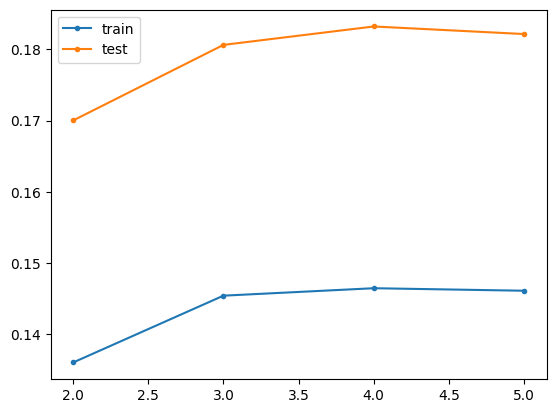

In [ ]:
# get the base autoencoder
model = base_autoencoder(X_train, X_test)
# evaluate the base model
scores = dict()
train_loss, test_loss = evaluate_autoencoder_as_classifier(model, X_train, y_train, X_test, y_test)
print('> loss layers=%d, train=%.3f, test=%.3f' % (len(model.layers), train_loss, test_loss))
scores[len(model.layers)] = (train_loss, test_loss)
# add layers and evaluate the updated model
n_layers = 3
for _ in range(n_layers):
  # add layer
  add_layer_to_autoencoder(model, X_train, X_test)
  # evaluate model
  train_loss, test_loss = evaluate_autoencoder_as_classifier(model, X_train, y_train, X_test, y_test)
  print('> loss layers=%d, train=%.3f, test=%.3f' % (len(model.layers), train_loss, test_loss))
  # store scores for plotting
  scores[len(model.layers)] = (train_loss, test_loss)
# plot number of added layers vs accuracy
keys = list(scores.keys())
pyplot.plot(keys, [scores[k][0] for k in keys], label='train', marker='.')
pyplot.plot(keys, [scores[k][1] for k in keys], label='test', marker='.')
pyplot.legend()
pyplot.show()

### Entrenamiento de capa predictora

In [ ]:
  for layer in model.layers:
    layer.trainable = False
    # add new output layer
  model.add(Dense(y_train.shape[1], activation='linear'))
    # compile model
  model.compile(loss='mse', optimizer='adam')
    # fit model
  model.fit(X_train, y_train, epochs=50)
    # evaluate model
  train_loss = model.evaluate(X_train, y_train)
  test_loss = model.evaluate(X_test, y_test)
    # put the model back together
  model.compile(loss='mse', optimizer='adam')

Epoch 1/50
147/147 [==============================] - 1s 2ms/step - loss: 0.7530
Epoch 2/50
147/147 [==============================] - 0s 2ms/step - loss: 0.3603
Epoch 3/50
147/147 [==============================] - 0s 2ms/step - loss: 0.2531
Epoch 4/50
147/147 [==============================] - 0s 2ms/step - loss: 0.2050
Epoch 5/50
147/147 [==============================] - 0s 2ms/step - loss: 0.1812
Epoch 6/50
147/147 [==============================] - 0s 2ms/step - loss: 0.1685
Epoch 7/50
147/147 [==============================] - 0s 2ms/step - loss: 0.1625
Epoch 8/50
147/147 [==============================] - 0s 2ms/step - loss: 0.1587
Epoch 9/50
147/147 [==============================] - 0s 2ms/step - loss: 0.1559
Epoch 10/50
147/147 [==============================] - 0s 2ms/step - loss: 0.1546
Epoch 11/50
147/147 [==============================] - 0s 2ms/step - loss: 0.1537
Epoch 12/50
147/147 [==============================] - 0s 2ms/step - loss: 0.1524
Epoch 13/50
147/147 [====

### Arquitectura Final

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 200)               43400     
                                                                 
 dense_5 (Dense)             (None, 200)               40200     
                                                                 
 dense_7 (Dense)             (None, 200)               40200     
                                                                 
 dense_9 (Dense)             (None, 200)               40200     
                                                                 
 dense_3 (Dense)             (None, 216)               43416     
                                                                 
 dense_11 (Dense)            (None, 27)                5859      
                                                                 
Total params: 213275 (833.11 KB)
Trainable params: 585

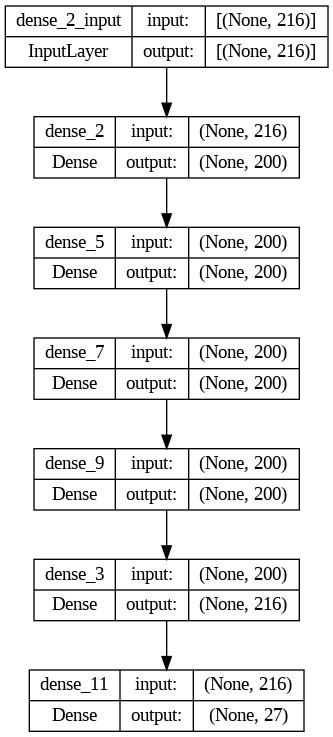

In [ ]:
keras.utils.plot_model(model, show_shapes= True)

### Predicción en datos de validación

In [ ]:
# Make predictions
predictions = model.predict(X_test)

# Inverse transform the scaled predictions to get actual values
y_test = scaler.inverse_transform(y_test)
predictions = scaler.inverse_transform(predictions)

37/37 [==============================] - 0s 2ms/step


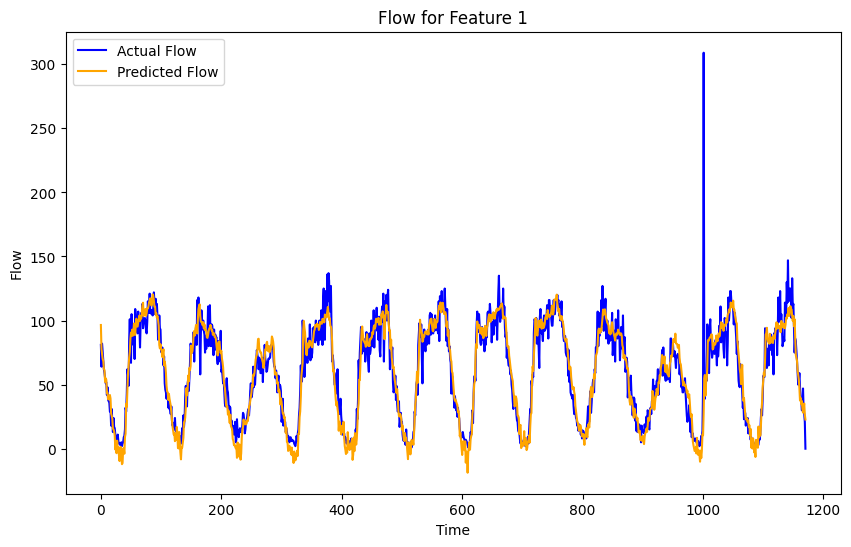

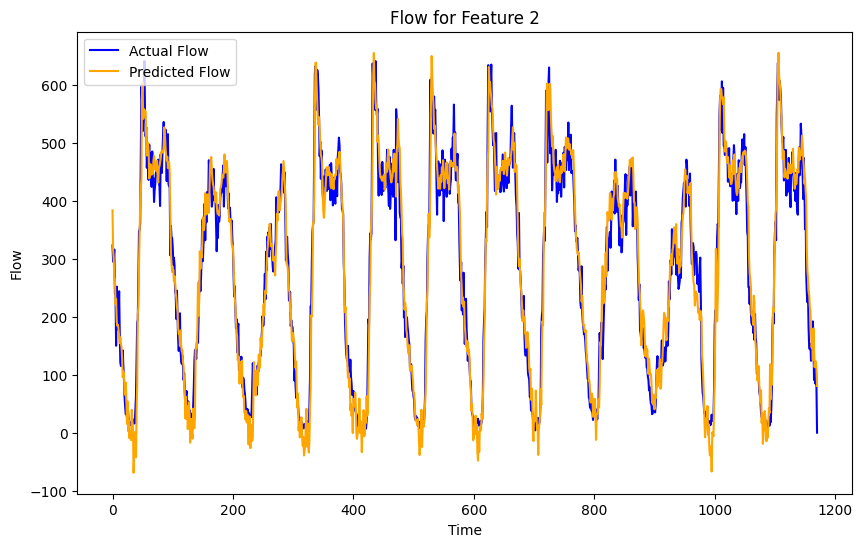

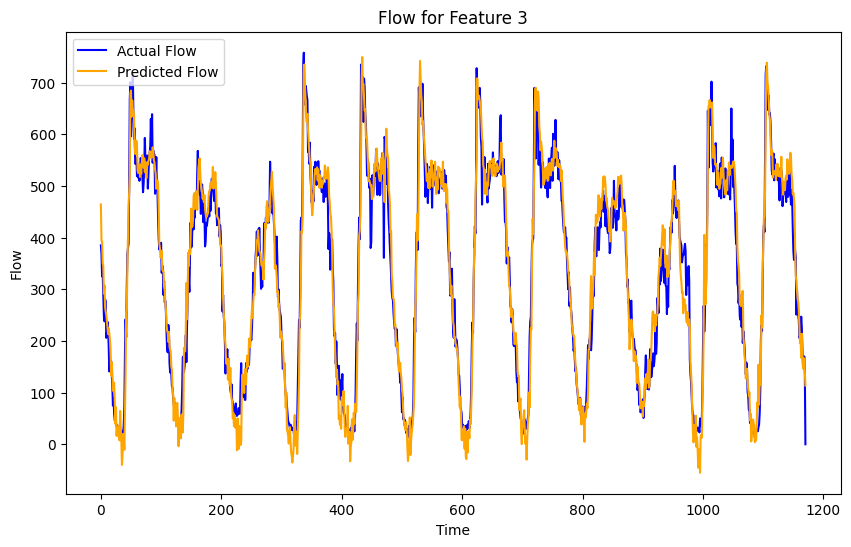

In [ ]:
# prompt: plot the predictions and the actual flow for some of the 146 features independantly

import matplotlib.pyplot as plt

# Select a few features to plot
features_to_plot = [0, 1, 2]

# Plot the predictions and actual flow for each selected feature
for i in features_to_plot:
  plt.figure(figsize=(10, 6))
  plt.plot(y_test[:, i], label="Actual Flow", color="blue")
  plt.plot(predictions[:, i], label="Predicted Flow", color="orange")
  plt.title(f"Flow for Feature {i + 1}")
  plt.xlabel("Time")
  plt.ylabel("Flow")
  plt.legend()
  plt.show()



### Preprocesameinto secundario - Datos de test

In [ ]:
data_val = df_val[['latitud_longitud', 'velocidad_agrupada', 'volumen_agrupada']]
# Paso 2: Creación de Lags
lags = 4  # Supongamos que se consideran los últimos 5 periodos de tiempo para predecir
# Crear lag features para velocidad y volumen
for lag in range(1, lags+1):
    # Crear lag features
    data_val[f'velocidad_lag_{lag}'] = data_val.groupby('latitud_longitud')['velocidad_agrupada'].shift(lag)
    data_val[f'volumen_lag_{lag}'] = data_val.groupby('latitud_longitud')['volumen_agrupada'].shift(lag)

    # Verificar la forma de las matrices generadas
    lag_velocidad_shape = data_val[f'velocidad_lag_{lag}'].shape
    lag_volumen_shape = data_val[f'volumen_lag_{lag}'].shape
# Eliminar filas con NaN resultantes de los lags
data_val.dropna(inplace=True)

# Paso 3: Apilamiento de Datos
# Agrupa las lag features de velocidad y volumen para cada avenida en un solo tensor
X_val = data_val.groupby('latitud_longitud').apply(lambda x: x.iloc[:, 3:].values)

<ipython-input-68-f0819d875ad9>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_val[f'velocidad_lag_{lag}'] = data_val.groupby('latitud_longitud')['velocidad_agrupada'].shift(lag)
<ipython-input-68-f0819d875ad9>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_val[f'volumen_lag_{lag}'] = data_val.groupby('latitud_longitud')['volumen_agrupada'].shift(lag)


In [ ]:
Y_val = data_val.groupby('latitud_longitud')['volumen_agrupada'].agg(list)

In [ ]:
X_val = np.stack(X_val)
# Verificar la forma del tensor resultante
print("Dimensiones del x de entrada:", X_val.shape)
y_val = np.stack(Y_val)
# Verificar la forma del tensor resultante
print("Dimensiones del y de entrada:", y_val.shape)

Dimensiones del x de entrada: (27, 2877, 8)
Dimensiones del y de entrada: (27, 2877)


In [ ]:
X_val = np.transpose(X_val, axes=(1, 0, 2))

X_reshaped_val = X_val.reshape(X_val.shape[0], -1)

y_val = np.transpose(y_val, axes=(1, 0))

In [ ]:
y_val.shape

(2877, 27)

In [ ]:
scaler = StandardScaler()
X_val = scaler.fit_transform(X_reshaped_val)
y_val = scaler.fit_transform(y_val)

### Predicción sobre datos de test

In [ ]:
# Make predictions
predictions_val = model.predict(X_val)


90/90 [==============================] - 1s 6ms/step


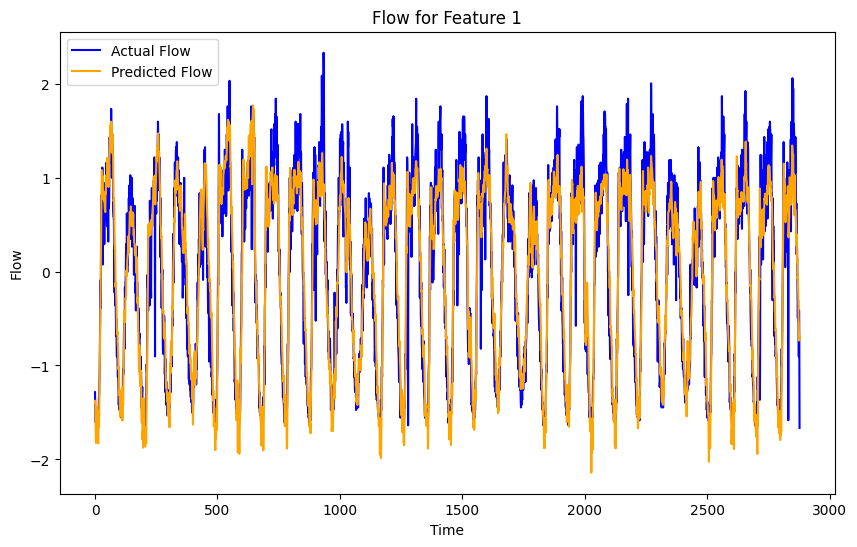

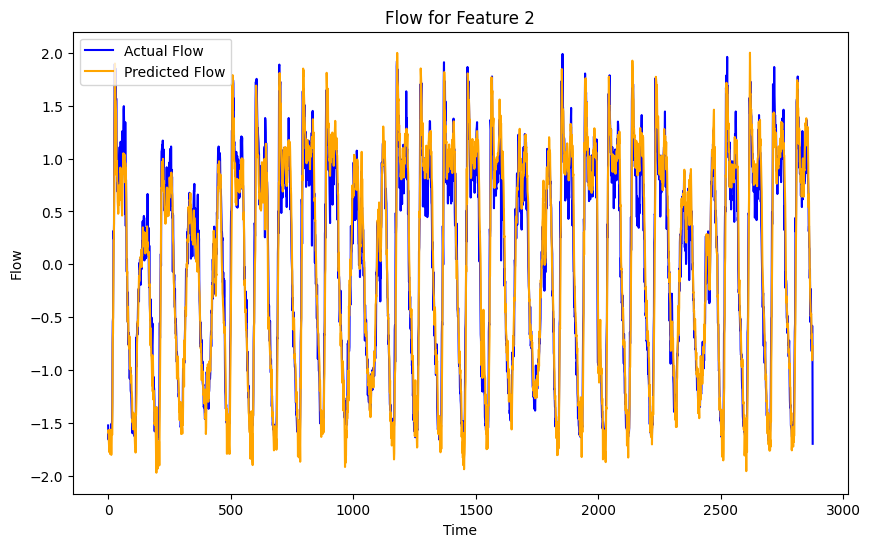

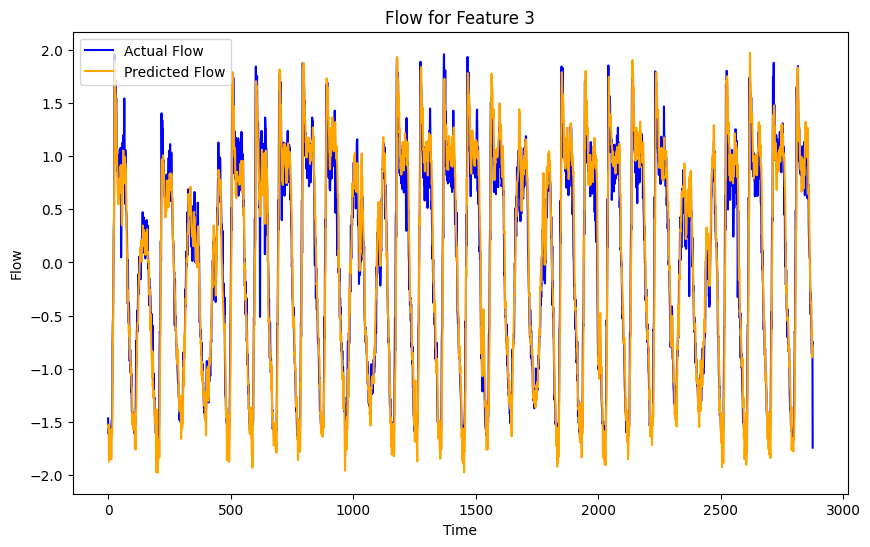

In [ ]:
import matplotlib.pyplot as plt

# Select a few features to plot
features_to_plot = [0, 1, 2]

# Plot the predictions and actual flow for each selected feature
for i in features_to_plot:
  plt.figure(figsize=(10, 6))
  plt.plot(y_val[:, i], label="Actual Flow", color="blue")
  plt.plot(predictions_val[:, i], label="Predicted Flow", color="orange")
  plt.title(f"Flow for Feature {i + 1}")
  plt.xlabel("Time")
  plt.ylabel("Flow")
  plt.legend()
  plt.show()

In [ ]:
# prompt: calculate mae of prediction and y_val

mse = mean_squared_error(y_val, predictions_val)
print("Mean squared error:", mse)


Mean squared error: 0.20692586075626715
